# M5 Project

In this project you will solve a robot localization problem using the particle filtering technique. The problem is illustrated in the figures below. You will have two types of robots: the pacman (triangle) and the ghost (pentagon). The pacman can measure its distance to the landmarks (blue circles), but the ghost can only measure its distance to the pacman. The environment is cyclic, so when the pacman or the ghost cross one of the sides, it appears in the opposite side. You will have to code the downweigh and resample steps of the particle filtering code provided as starting point.

<img src="m5project1.png" width="400"/><img src="m5project2.png" width="400"/><img src="m5project3.png" width="400"/>

An initial version of the code with the problem specification (below) and a report template (at the bottom) are available in this notebook. Deliverables are the final code (non-functioning code is worth 0 points) and the report.

You must implement:
- downweigh and resample steps for the pacman (20pts)
- downweigh and resample steps for the ghost (20pts)

For your solution, describe the:
- how you updated the ghost particles without having the real location of the pacman (20pts)
- which other alternatives have you considered, and why you decided not to use them (10pts)

Run your code at least 10 times and:
- compare the uncertainty in the location of the pacman and the ghost over time (15pts)
- explain what causes the ghost particles to concentrate in a well-defined cluster (15pts) - see the rightmost picture above

# Implementation

In this project, you can only modify the last cell of code. The area that can be modified is marked between the comments "YOUR CODE STARTS HERE" and "YOUR CODE ENDS HERE".

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# world configuration
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

# generic robot implementation
class robot:
    def __init__(self):
        # initialise robot with random location and orientation
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * math.pi
        
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * math.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    # apply noisy movement to robot
    def new_position(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (math.cos(orientation) * dist)
        y = self.y + (math.sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size

        return x, y, orientation
    
    # model noise using Gaussians
    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
# PacMan class
class pacman(robot):
    # the PacMan can sense its location using the landmarks
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement):
        prob = 1.0
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob

    def move(self, turn, forward):
        x, y, orientation = self.new_position(turn, forward)
        res = pacman()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

# Ghost class
class ghost(robot):
    # the PacMan ("mypacman") can sense its distance to the ghost
    def sense(self, mypacman):
        Z = math.sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2) + random.gauss(0.0, self.sense_noise)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement, mypacman):
        dist = math.sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2)
        prob = self.Gaussian(dist, self.sense_noise, measurement)
        return prob

    def move(self, turn, forward):
        x, y, orientation = self.new_position(turn, forward)
        res = ghost()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

In [3]:
# world visualization with the distribution of particles
def show_belief(mypacman, pacman_particles, myghost, ghost_particles):
    plt.rcParams["figure.figsize"] = (5,5)

    for p in pacman_particles:
        plt.plot(p.x, p.y, marker=(3, 0, 180.0*p.orientation/math.pi), markerfacecolor='red', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(mypacman.x, mypacman.y, marker=(3, 0, 180.0*mypacman.orientation/math.pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

    for p in ghost_particles:
        plt.plot(p.x, p.y, marker=(5, 0, 180.0*p.orientation/math.pi), markerfacecolor='green', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(myghost.x, myghost.y, marker=(5, 0, 180.0*myghost.orientation/math.pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

    for x, y in landmarks:
          plt.plot(x, y, marker='o', markersize=20, markeredgewidth=2.0, markerfacecolor='None', markeredgecolor='blue')

    plt.xlim([0,100])
    plt.ylim([0,100])

    plt.show()

# measure the proximity between the real location and the distribution of particles
def eval(r, p):
    s = 0.0;
    for i in range(len(p)):
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = math.sqrt(dx * dx + dy * dy)
        s += err
    return s / float(len(p))

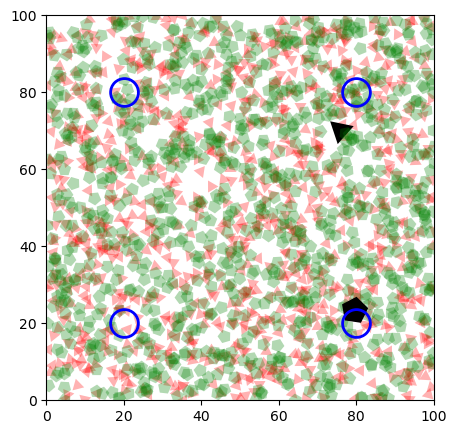

Average pacman distance: 38.308026537963464
Average ghost distance: 37.917158563530485


In [4]:
# pacman/ghost initialization
forward_noise = 3.0 
turn_noise = 0.05
sense_noise = 3.0

mypacman = pacman()
mypacman.set_noise(forward_noise, turn_noise, sense_noise)

myghost = ghost()
myghost.set_noise(forward_noise, turn_noise, sense_noise)

# particle distribution
N = 1000 # number of particles
T = 10   # number of moves

# initialise randomly guessed particles for pacman and ghost
p = []
g = []
for i in range(N):
    x = pacman()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    p.append(x)
    x = ghost()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    g.append(x)

show_belief(mypacman, p, myghost, g)

print("Average pacman distance:", eval(mypacman, p))
print("Average ghost distance:", eval(myghost, g))


Turn #1


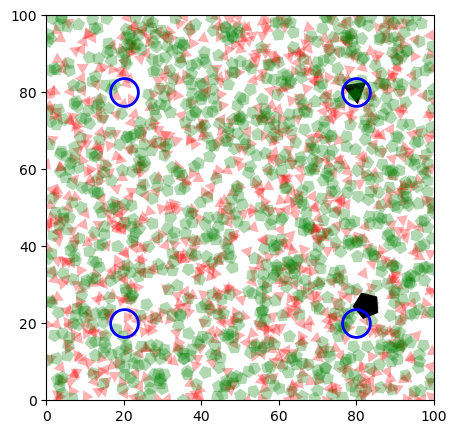

Average pacman distance before resample: 38.13502398181959
Average ghost distance before resample: 37.95807602572065


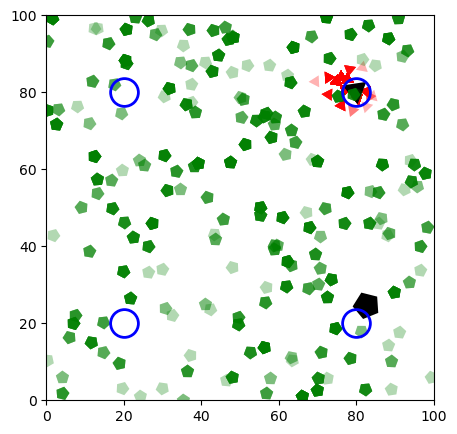

Average pacman distance after resample: 3.895878426829922
Average ghost distance after resample: 38.91535610300768

Turn #2


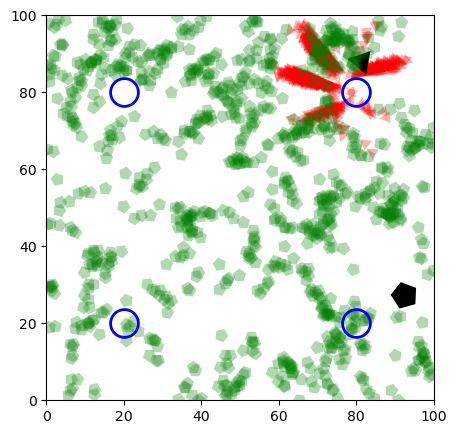

Average pacman distance before resample: 12.01611355792567
Average ghost distance before resample: 39.69119396370026


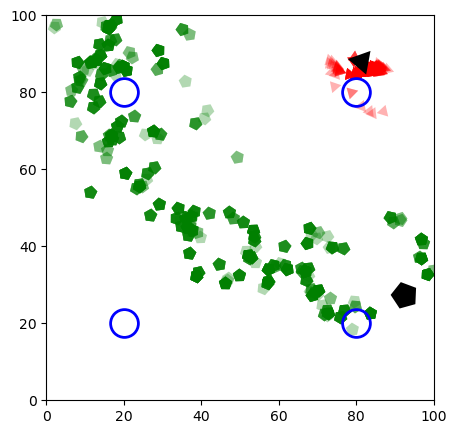

Average pacman distance after resample: 3.419595147687329
Average ghost distance after resample: 39.07064062865188

Turn #3


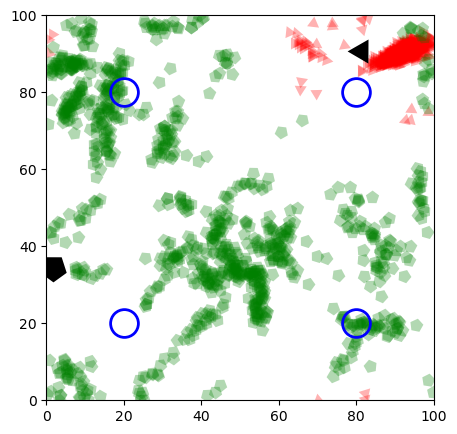

Average pacman distance before resample: 11.094075262138755
Average ghost distance before resample: 38.79587506507361


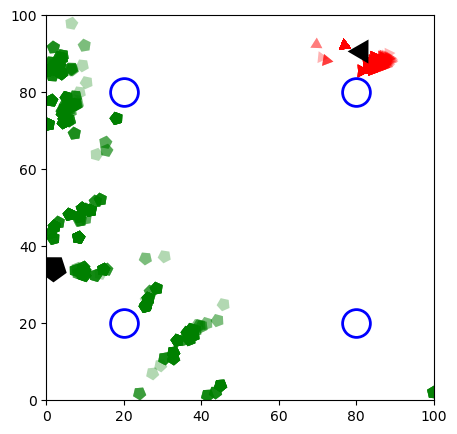

Average pacman distance after resample: 4.732922973888202
Average ghost distance after resample: 32.12166517919421

Turn #4


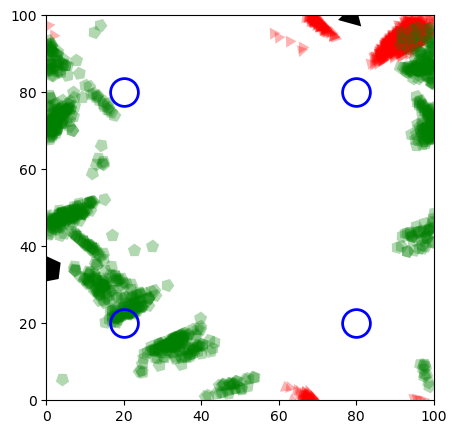

Average pacman distance before resample: 14.102464646582758
Average ghost distance before resample: 31.663429356937517


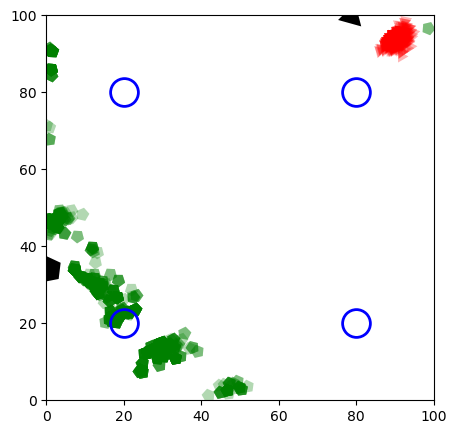

Average pacman distance after resample: 12.88455592896667
Average ghost distance after resample: 25.712218302957943

Turn #5


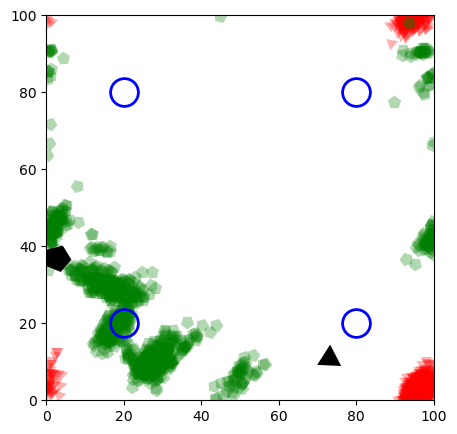

Average pacman distance before resample: 24.648865698536945
Average ghost distance before resample: 25.722667457586127


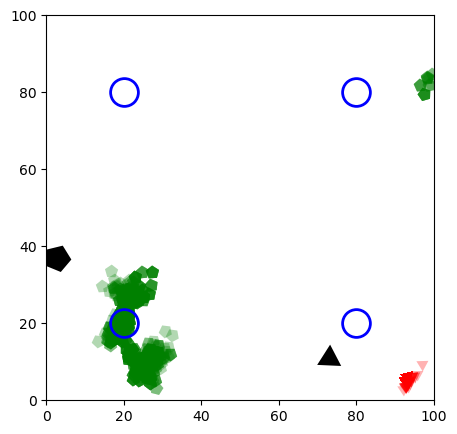

Average pacman distance after resample: 20.54809833994595
Average ghost distance after resample: 29.56309716807136

Turn #6


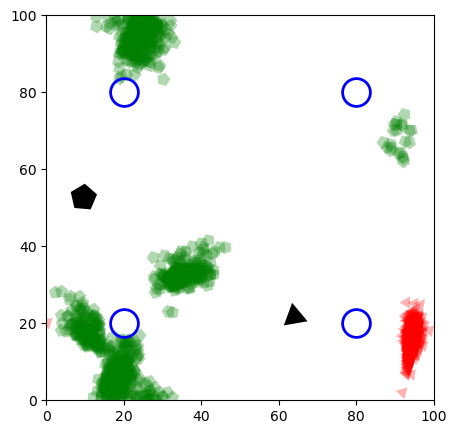

Average pacman distance before resample: 31.116535591917433
Average ghost distance before resample: 41.000242650804985


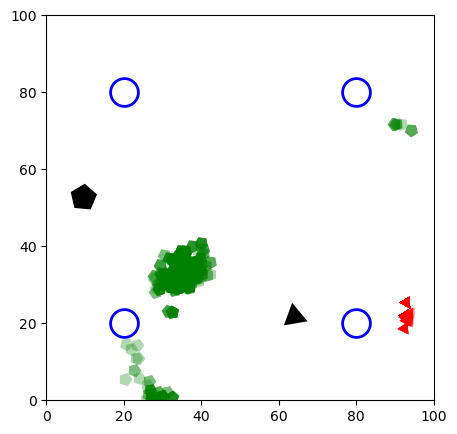

Average pacman distance after resample: 29.097047909490815
Average ghost distance after resample: 33.153301983169115

Turn #7


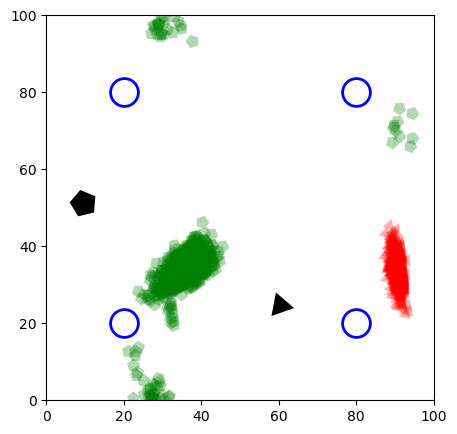

Average pacman distance before resample: 31.815952744786124
Average ghost distance before resample: 32.73631554661587


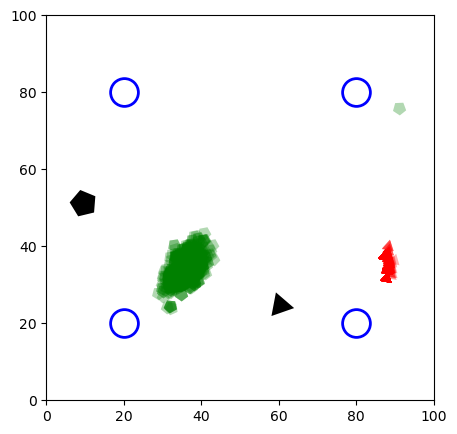

Average pacman distance after resample: 29.652845972555564
Average ghost distance after resample: 31.716502514240478

Turn #8


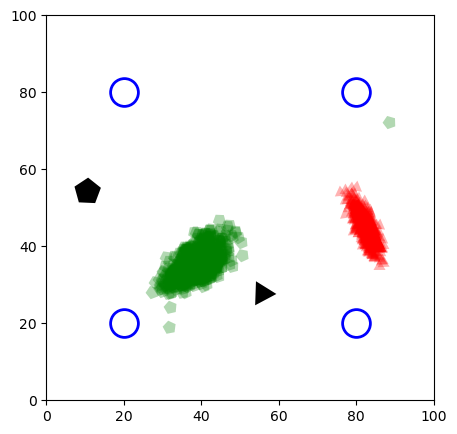

Average pacman distance before resample: 32.18853005848796
Average ghost distance before resample: 34.22892968876922


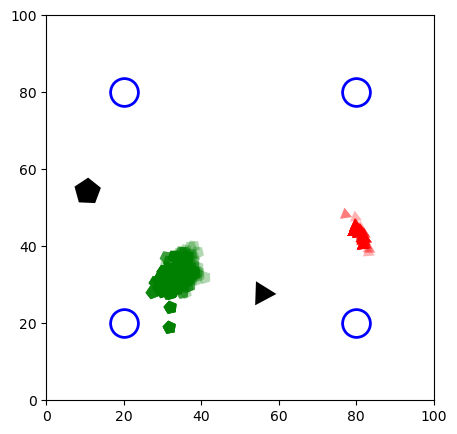

Average pacman distance after resample: 28.900262085774553
Average ghost distance after resample: 31.739855786784403

Turn #9


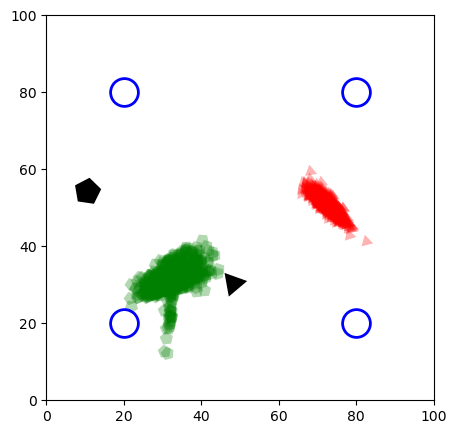

Average pacman distance before resample: 31.792510975028375
Average ghost distance before resample: 31.86448431437605


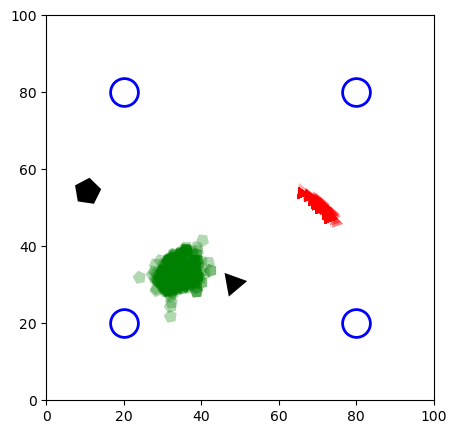

Average pacman distance after resample: 29.768300035160053
Average ghost distance after resample: 31.939442869197713

Turn #10


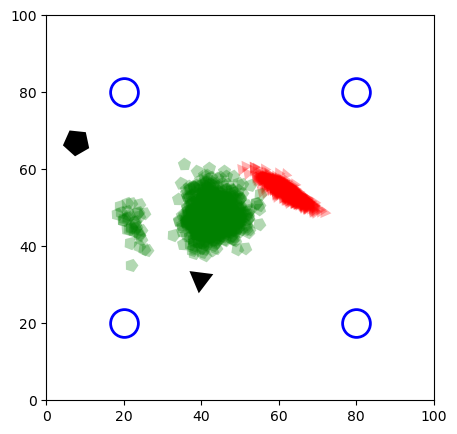

Average pacman distance before resample: 32.085099832818415
Average ghost distance before resample: 39.62605212181423


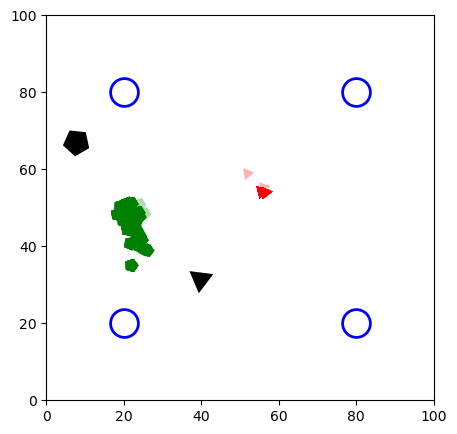

Average pacman distance after resample: 27.815985271672975
Average ghost distance after resample: 25.155735521110238


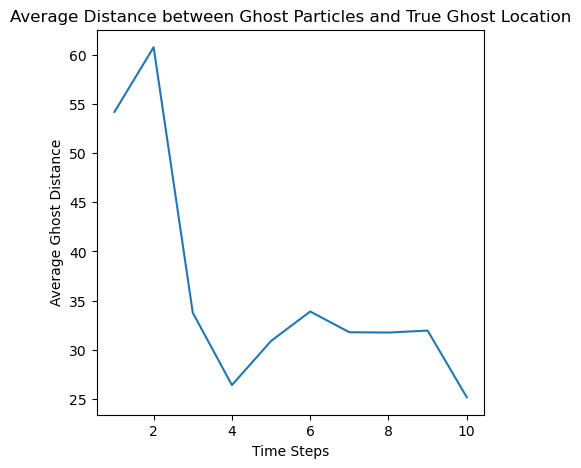

In [5]:
average_ghost_distance = [] 
for turn in range(T):
    print('\nTurn #{}'.format(turn+1))

    # real pacman movement
    # turn 0.1 and move 10 meters
    mypacman = mypacman.move(0.2, 10.0)

    # real move for ghost (random)
    gturn = (random.random()-0.5)*(math.pi/2.0) # random angle in [-45,45]
    gdist = random.random()*20.0           # random distance in [0,20]
    myghost = myghost.move(gturn, gdist)

    # elapse time
    # move particles using the same movement made by robot
    p2 = []
    g2 = []
    for i in range(N):
        p2.append(p[i].move(0.2, 10.0))
        g2.append(g[i].move(gturn, gdist))
    p = p2
    g = g2

    show_belief(mypacman, p, myghost, g)
    print("Average pacman distance before resample:", eval(mypacman, p))
    print("Average ghost distance before resample:", eval(myghost, g))

    # observe
    ZP = mypacman.sense()        # noisy measurement of the distance between the pacman and the landmarks
    ZG = myghost.sense(mypacman) # noisy measurement of the distance between the pacman and the ghost

    ###################################
    ###################################
    ###################################
    ###### YOUR CODE STARTS HERE ######
    ###################################
    ###################################
    ###################################





    # downweight and resample pacman and ghost particles here - check the Particle Filtering lecture for an example
    # particles do not know the real location of the pacman and the ghost, so you cannot access "mypacman" and "myghost" in here
    # remember that you can still use p and g, which can be used to estimate the location of the pacman and the ghost
    # you should use the obtained measurements from the sensors to update the particles
    # - ZP contains the observed distances between the pacman and the landmarks
    # - ZG is the observed distance between the pacman and the ghost
    # downweight and resample pacman and ghost particles here
    
    # Downweight pacman particles
    w_pacman = []
    for particle in p:
        weight = particle.measurement_prob(ZP) # Calculates measurement probability for each pacman particle
        w_pacman.append(weight)
    
    # Downweight ghost particles
    w_ghost = []
    for i, particle in enumerate(g):
        weight = particle.measurement_prob(ZG, p[i])  # Use p[i] instead of mypacman
        w_ghost.append(weight)
    
    # Resample pacman particles
    p2 = []
    index_pacman = int(random.random() * N)  # Selecting Random index to start resampling
    beta_pacman = 0.0
    max_weight_pacman = max(w_pacman)
    for i in range(N):
        beta_pacman += random.random() * 2.0 * max_weight_pacman
        while beta_pacman > w_pacman[index_pacman]:
            beta_pacman -= w_pacman[index_pacman]
            index_pacman = (index_pacman + 1) % N
        p2.append(p[index_pacman]) # Create new particle
    
    # Resample ghost particles
    g2 = []
    index_ghost = int(random.random() * N)  # Selecting Random index to start resampling
    beta_ghost = 0.0
    max_weight_ghost = max(w_ghost)
    for i in range(N):
        beta_ghost += random.random() * 2.0 * max_weight_ghost
        while beta_ghost > w_ghost[index_ghost]:
            beta_ghost -= w_ghost[index_ghost]
            index_ghost = (index_ghost + 1) % N
        g2.append(g[index_ghost]) # Create new particle
    
    # Update list p and g with resampled particles
    p = p2
    g = g2
    
    total_ghost_distance = 0.0
    for ghost_particle in g:
        dist = math.sqrt((ghost_particle.x - myghost.x) ** 2 + (ghost_particle.y - myghost.y) ** 2)
        total_ghost_distance += dist
    avg_ghost_distance = total_ghost_distance / N
    average_ghost_distance.append(avg_ghost_distance)

    #################################
    #################################
    #################################
    ###### YOUR CODE ENDS HERE ######
    #################################
    #################################
    #################################

    show_belief(mypacman, p, myghost, g)
    print("Average pacman distance after resample:", eval(mypacman, p))
    print("Average ghost distance after resample:", eval(myghost, g))

plt.plot(range(1, T + 1), average_ghost_distance)
plt.xlabel('Time Steps')
plt.ylabel('Average Ghost Distance')
plt.title('Average Distance between Ghost Particles and True Ghost Location')
plt.show()

# Report template

## Solution description

How you updated the ghost particles without having the real location of the pacman?

To update the ghost particles without having the real location of the pacman, I used the observed distance between the pacman and the ghost (ZG) in the measurement_prob method of the ghost class. This method calculates the probability of the measurement given the distance between the ghost particle and the estimated location of the pacman.

Instead of using the real location of the pacman, I used the estimated location stored in the p list, which represents the distribution of pacman particles. By iterating through the g list of ghost particles and using the corresponding pacman particle from p in the measurement probability calculation, I updated the weights of the ghost particles based on the observed distance.


Which other alternatives have you considered, and why you decided not to use them?

Using the real location of the pacman: This approach would require accessing the real location of the pacman, which is not available in the provided code. Therefore, I used the estimated location of the pacman particles in p as a substitute.

Incorporating additional measurements: If there were additional measurements or sensor readings available that could provide information about the positions of the ghost particles relative to other landmarks or objects in the environment, those measurements could be used to more accurately update the weights of the ghost particles. However, in the provided code, the only measurement available is the distance between the pacman and the ghost.

## Experimental results

Here I compare the uncertainty in the location of the pacman and the ghost over time ...

The ghost particles tend to concentrate in a well-defined cluster when ...

The ghost particles tend to concentrate in a well-defined cluster when the pacman and ghost are close to each other. This is because the distance measurements between the pacman and ghost provide a strong signal to update the ghost particles. As the pacman gets closer to the ghost, the ghost particles that are closer to the actual location of the pacman have a higher probability of being selected and resampled, leading to a higher concentration of particles in the region where the pacman is located.

Similarly, the pacman particles are filtered and accumulate faster than the ghost particles since the ghost depends on the pacman. This causes the ghost to take a little longer to filter and accumulate its particles. However, after the 10 iterations, both robots achieve their goal.

On the other hand, the uncertainty in the pacman's location tends to decrease as more measurements are collected and resampling is performed. As the pacman moves and new measurements are obtained, the pacman particles that are closer to the true location have a higher probability of being selected and resampled, helping to refine the estimation of the pacman's location and reduce uncertainty.

## Corrections and Additions:
The map itself does not have its own sensors to aid in particle detection and filtering. However, the fact that when the particles leave the map on one side, they reappear on the opposite side is very helpful to the observer.

You are right, there is another factor in the code that can improve the predictability of the particle filter: the fact that the movement of the ghost is random. Although in the current code, the ghost's movement is determined by a random angle and distance, we can see that this factor can contribute to improving the filter's accuracy in certain situations.

When the ghost's movement is random, it's possible that in some iterations, the ghost moves away from the pacman, and in others, it gets closer. This creates a greater dispersion of particles around the pacman, allowing the particle filter to consider a wider range of possible ghost locations.

In the case where the ghost's movement was deterministic (i.e., it follows a predictable pattern), the particles would tend to cluster around a single ghost location, leading to a less accurate estimation of its position.

With the random movement of the ghost, the particle filter can be more robust against unexpected changes or unpredictable movements of the tracked object (in this case, the ghost). This randomness helps maintain a broader distribution of particles, covering various potential locations of the ghost, resulting in a more accurate estimation of its position over time.

Discussion on the final distance graph:
In the graph, we notice that in the first iteration or turn, there is a huge distance that gradually decreases as we reach the last iteration. This is a good sign that the filter is working and that, even though the robot occasionally moves randomly, causing the distance to temporarily increase, it quickly returns to normal. This behavior is clearly observed in turns 6-8, and we can see that by turn 10, the distance becomes minimal.